In [45]:
import math
import random
from collections import namedtuple
import operator
from itertools import chain
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Helper functions
def calculateDistance(bits):
    return math.fabs(sum(bitsToSet(bits)))

def bitsToSet(bits):
    set = []
    for i, bit in enumerate(list(bits)):
        if bit == True:
            set.append(DATA[i])
    return set

def getAllNeighbours(bits):
    allNeighbours = []

    for i in range(len(bits)):
        neighbour = []
        for bit in bits:
            neighbour.append(bit)
        neighbour[i] = (not neighbour[i])
        # Check if list isn't only [False, False, ...]
        if sum(neighbour) != 0:
            allNeighbours.append(neighbour)

    return allNeighbours

def getBestNeighbour(allNeighbours):
    if allNeighbours == []:
        return []
    allNeighboursDistance = {}
    for neighbour in allNeighbours:
        allNeighboursDistance[calculateDistance(neighbour)] = neighbour

    return allNeighboursDistance[min(allNeighboursDistance.keys())]

def getRandomNeighbour(bits):
    neighbour = []
    for bit in bits:
        neighbour.append(bit)

    randVal = random.choice(range(len(neighbour)))
    neighbour[randVal] = (not neighbour[randVal])

    return neighbour





# Solutions
class HillClimbing:
    def __init__(self):
        self.bits = BITS

    def execute(self):
        while True:
            bestNeighbour = getBestNeighbour(getAllNeighbours(self.bits))

            if calculateDistance(self.bits) > calculateDistance(bestNeighbour):
                self.bits = bestNeighbour
            else:
                return self.bits

class HillClimbingRandom:
    def __init__(self, iterationsLimit):
        self.bits = BITS
        self.iterationsLimit = iterationsLimit
        self.i = 1

    def execute(self):
        while self.i <= self.iterationsLimit:
            self.i += 1
            possibleNeighbour = getRandomNeighbour(self.bits)

            if calculateDistance(self.bits) > calculateDistance(possibleNeighbour):
                self.bits = possibleNeighbour
            else:
                return self.bits


class TabuAlgo:
    def __init__(self, iterationsLimit):
        self.bits = BITS
        self.iterationsLimit = iterationsLimit
        self.i = 1
        self.tabuList = []
        self.stepsHeap = []
        self.bestBits = self.bits

    def execute(self):
        self.stepsHeap.append(self.bits)
        while self.i <= self.iterationsLimit and calculateDistance(self.bits) != 0 and self.stepsHeap != []:
            self.i += 1
            allNeighbours = getAllNeighbours(self.bits)
            allPossibleNeighbours = [n for n in allNeighbours if n not in self.tabuList]
            bestNeighbour = getBestNeighbour(allPossibleNeighbours)
            
            self.tabuList.append(self.bits)
            if bestNeighbour == []:
                self.bits = self.stepsHeap.pop()
            else:
                if calculateDistance(self.bits) > calculateDistance(bestNeighbour):
                    self.stepsHeap.append(self.bits)
                    self.bestBits = bestNeighbour
                self.bits = bestNeighbour

        return self.bestBits

class SimulatedAnnealing:
    def __init__(self, iterationsLimit, temperature):
        self.bits = BITS
        self.i = 1
        self.iterationsLimit = iterationsLimit
        self.bestBits = self.bits
        self.temperature = temperature

    def execute(self):
        while self.i <= self.iterationsLimit and calculateDistance(self.bestBits) != 0:
            self.i += 1
            neighbour = random.choice(getAllNeighbours(self.bits))

            distanceDifference = calculateDistance(self.bits) - calculateDistance(neighbour)
            if distanceDifference > 0:
                self.bits = neighbour
            else:
                # Zmniejszenie temperatury
                # Metoda z dzieleniem / Slow decrease
                # t = Energy magnitude
                t = abs(distanceDifference) / (self.temperature / math.log(self.i))
                if random.random() < math.exp(t):
                    self.bits = neighbour

            if calculateDistance(self.bestBits) > calculateDistance(self.bits):
                self.bestBits = self.bits

        return self.bestBits


class GeneticAlgorithm:
    def __init__(self, iterationsLimit, populationSize, methodCross=0, methodMutation=0, methodTerminiation=0):
        self.bits = BITS
        self.i = 1
        self.iterationsLimit = iterationsLimit
        self.bestBits = self.bits
        self.population = []
        self.populationSize = populationSize

        self.methodCross = methodCross
        self.methodMutation = methodMutation
        self.methodTerminiation = methodTerminiation

        self.typeCross = [lambda x,y: self.crossover1(x,y), lambda x,y: self.crossover2(x,y)]
        self.typeMutation = [lambda x: self.mutate1(x), lambda x: self.mutate1(x)]
        self.typeTermination = [lambda :self.terminationCond1(), lambda :self.terminationCond2()]
    
    def execute(self):
        Sample = namedtuple("Sample",["bits", "distance"])
        self.population = [
            Sample(bits, calculateDistance(bits))
            for bits in self.getInitialPopulation()
        ]

        while not self.typeTermination[self.methodTerminiation]():
            self.i += 1

            # Selection
            maxDistance = max([sample.distance for sample in self.population])
            self.population = random.choices(
                    population=self.population,
                    weights=[maxDistance-sample.distance+1 for sample in self.population],
                    k=int(self.populationSize/2))

            

            # Mating
            kids = []
            maxDistance = max([sample.distance for sample in self.population])
            while (len(self.population) + len(kids)) < self.populationSize:
                matingPair = random.choices(
                    population=self.population,
                    weights=[maxDistance-sample.distance+1 for sample in self.population],
                    k=2)
                # Crossover
                kid = self.typeCross[self.methodCross](matingPair[0],matingPair[1])
                # Mutation
                kid = self.typeMutation[self.methodMutation](kid)

                if sum(kid.bits) != 0: # Check if list isn't only [False, False, ...]
                    kids.append(kid)
            self.population = self.population + kids

            # Save best result
            self.population = sorted(
                self.population,
                key=operator.attrgetter("distance")
            )
            if calculateDistance(self.bestBits) > calculateDistance(self.population[0].bits):
                self.bestBits = self.population[0].bits

        return self.bestBits

    def terminationCond1(self):
        return calculateDistance(self.bestBits) == 0 or self.i > self.iterationsLimit

    def terminationCond2(self):
        return self.i > self.iterationsLimit

    def getInitialPopulation(self):
        population = []
        i = 0
        while i < self.populationSize:
            member = []
            for _ in range(len(self.bits)):
                member.append(random.choice([True, False]))
            # If isn't all False
            if sum(member) > 0:
                population.append(member)
                i += 1

        return population

    def crossover1(self, sample1, sample2):
        Sample = namedtuple("Sample",["bits", "distance"])
        point = random.choice(range(len(self.bits)-1))
        bits = sample1.bits[:point] + sample2.bits[point:]
        return Sample(bits, calculateDistance(bits))

    def crossover2(self, sample1, sample2):
        Sample = namedtuple("Sample",["bits", "distance"])
        points = sorted([random.choice(range(len(self.bits)-1)), random.choice(range(len(self.bits)-1))])
        bits = sample1.bits[:points[0]] + sample2.bits[points[0]:points[1]] + sample1.bits[points[1]:]
        return Sample(bits, calculateDistance(bits))

    def mutate1(self, kid):
        if random.random() < 0.1:
            randVal = randVal = random.choice(range(len(kid.bits)))
            kid.bits[randVal] = not kid.bits[randVal]
        return kid

    def mutate2(self, kid):
        if random.random() < 0.1:
            randVal = randVal = random.choice(range(len(kid.bits)))
            kid.bits[randVal] = not kid.bits[randVal]
        if random.random() < 0.5:
            randVal = randVal = random.choice(range(len(kid.bits)))
            kid.bits[randVal] = not kid.bits[randVal]
        return kid

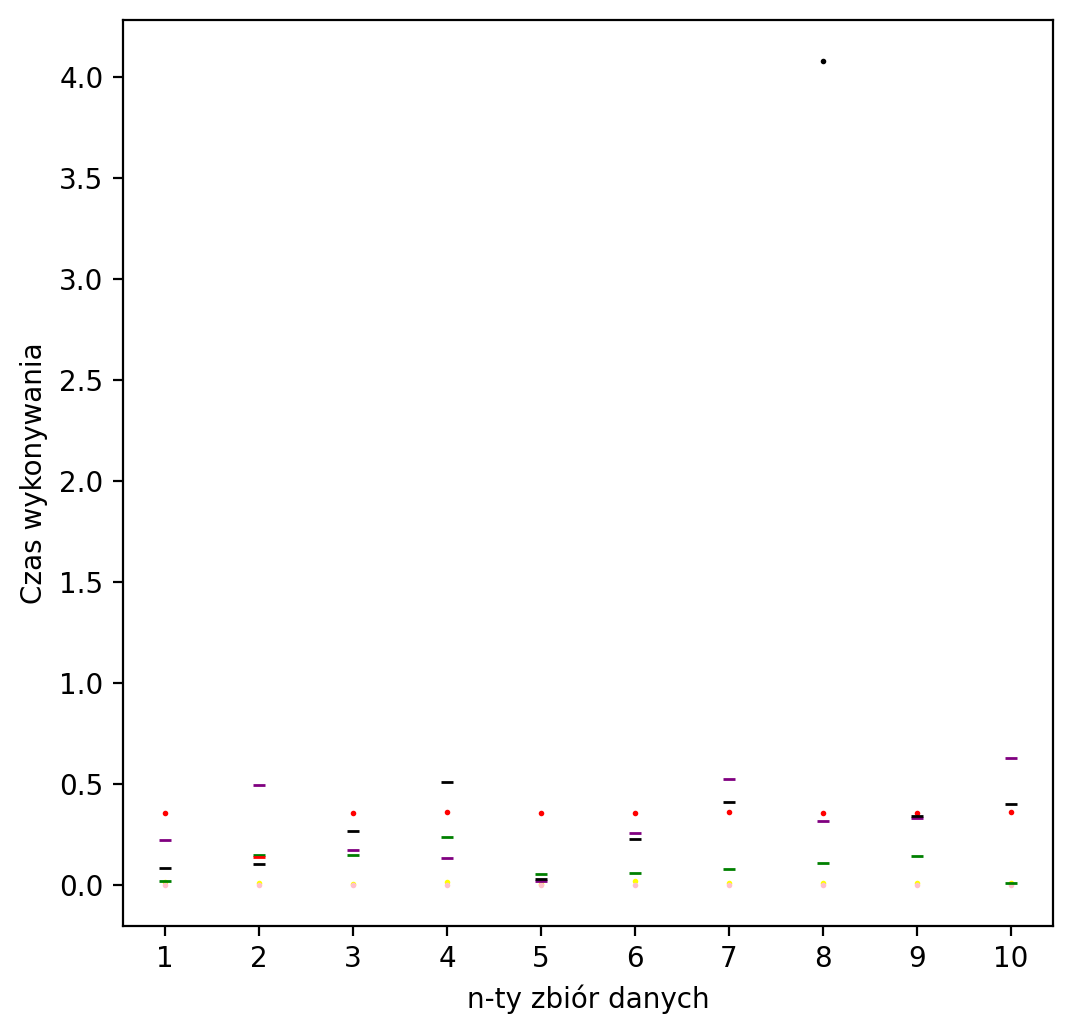

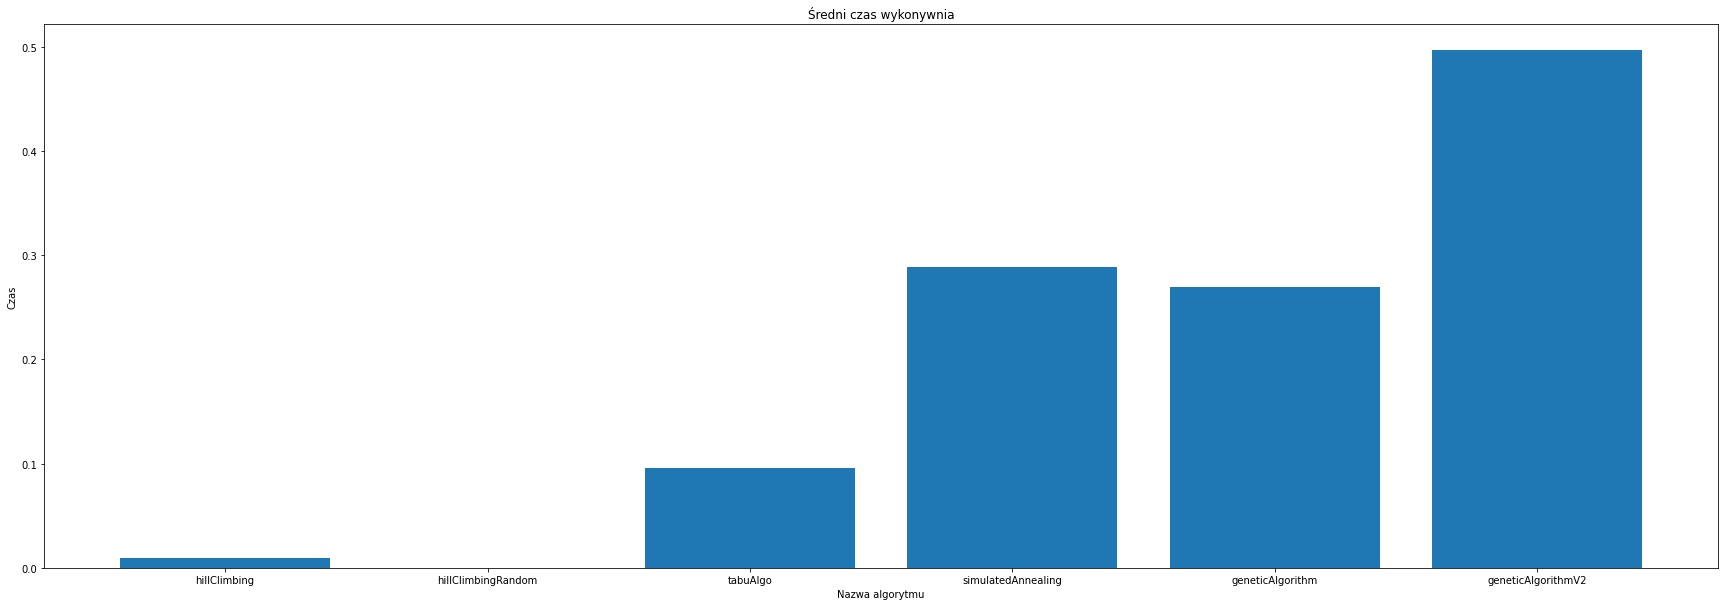

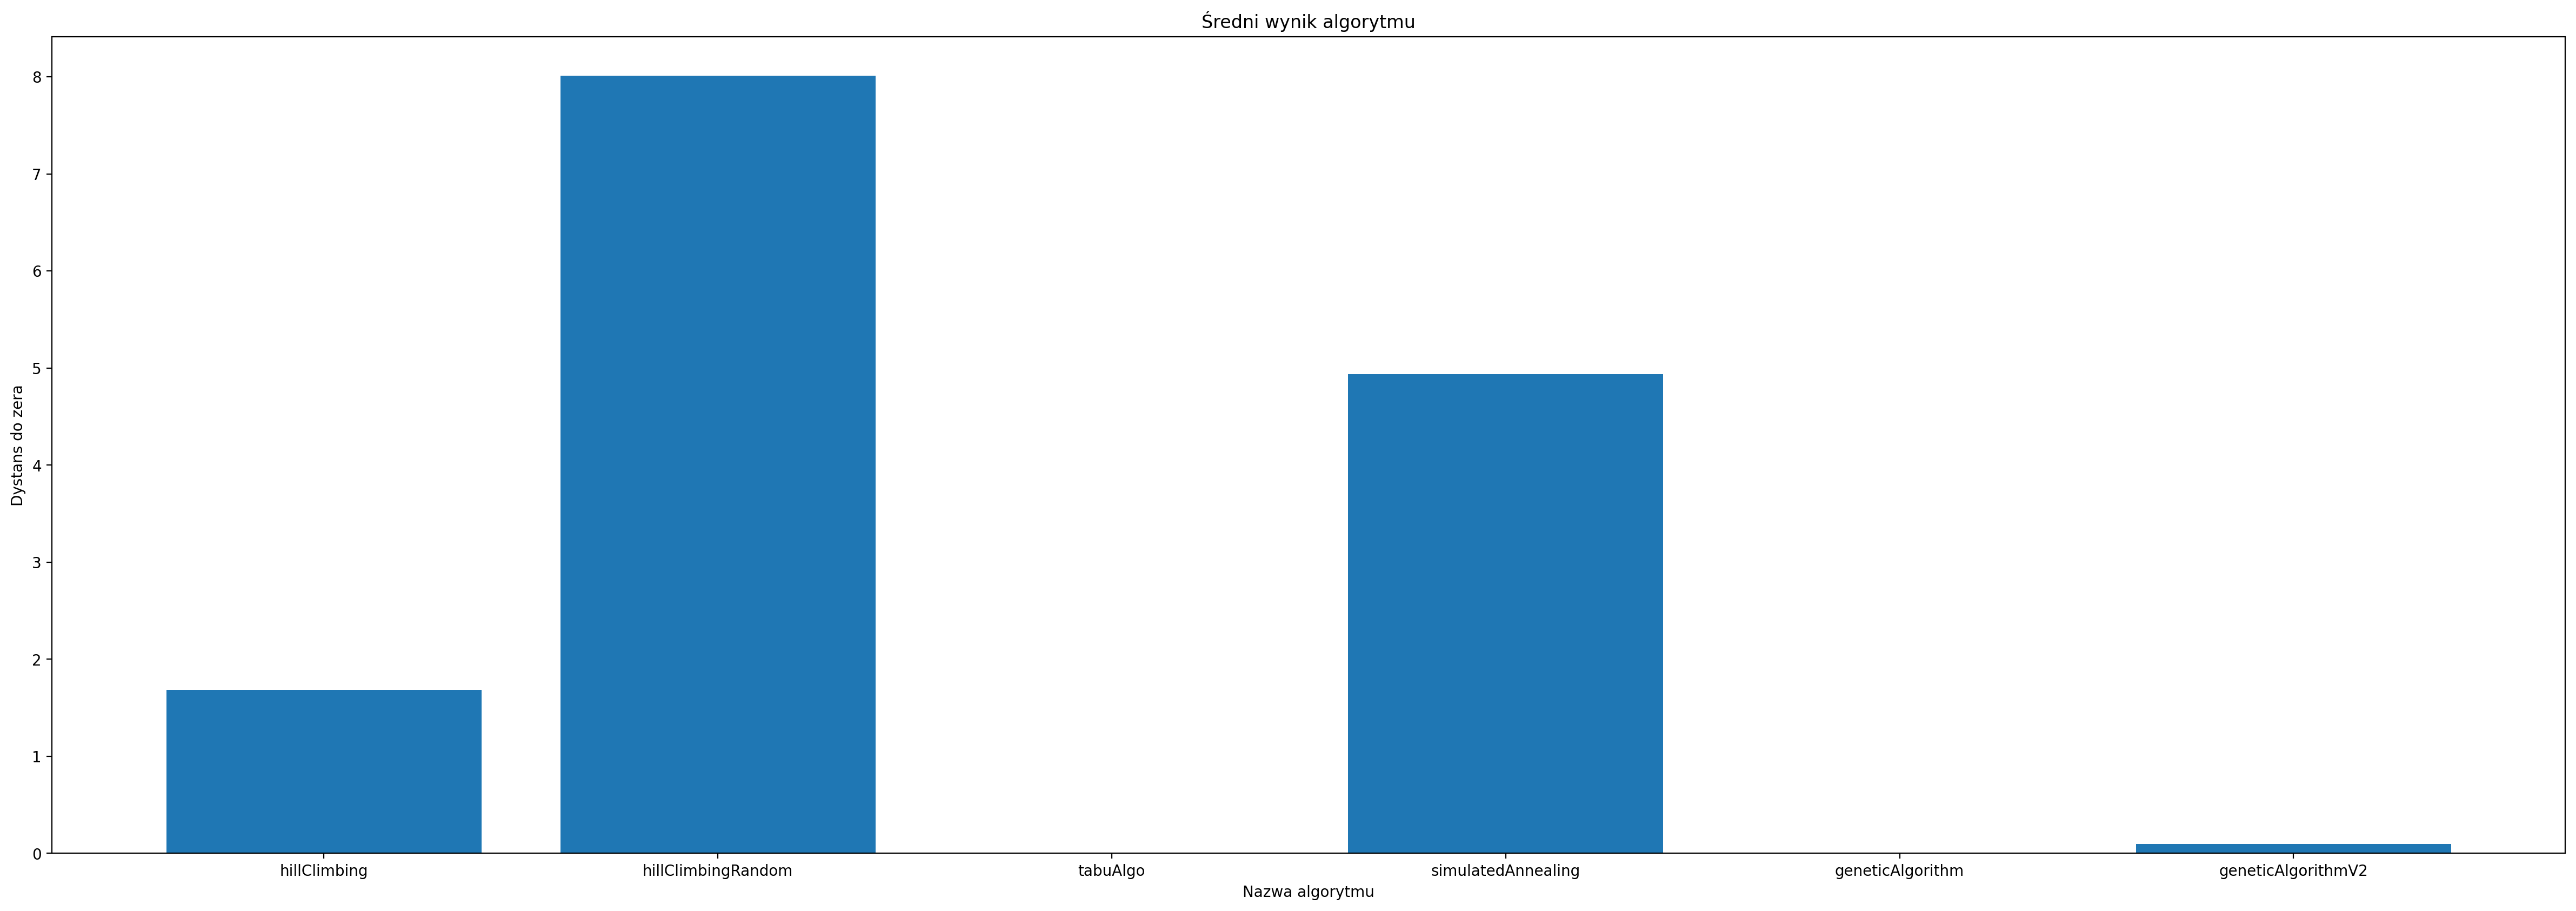

In [48]:
MAX_ITERATIONS = 500
ALGO_LIST = {
    'hillClimbing':         lambda: HillClimbing().execute(),
    'hillClimbingRandom':   lambda: HillClimbingRandom(MAX_ITERATIONS).execute(),
    'tabuAlgo':             lambda: TabuAlgo(MAX_ITERATIONS).execute(),
    'simulatedAnnealing':   lambda: SimulatedAnnealing(MAX_ITERATIONS, 500000).execute(),
    'geneticAlgorithm':     lambda: GeneticAlgorithm(MAX_ITERATIONS, 200).execute(),
    'geneticAlgorithmV2':   lambda: GeneticAlgorithm(MAX_ITERATIONS, 200,1,1).execute()
}

results = {}
[results.update({name : {
    "time": [],
    "sum": []
    }}) for name in ALGO_LIST]
    
LOOP_AMOUNT = 10
RANGE       = 1000
AMOUNT      = 100
for _ in range(LOOP_AMOUNT):
    DATA = [random.randint(-RANGE,RANGE) for _ in range(AMOUNT)]
    BITS = [random.choice([True, False]) for _ in range(AMOUNT)]

    for name, algo in ALGO_LIST.items():
        t = time()
        bestBits = algo()
        results[name]["time"].append(time() - t)
        results[name]["sum"].append(calculateDistance(bestBits))

COLOR_LIST = {
    'hillClimbing':         "yellow",
    'hillClimbingRandom':   "pink",
    'tabuAlgo':             "green",
    'simulatedAnnealing':   "red",
    'geneticAlgorithm':     "purple",
    'geneticAlgorithmV2':   "black"
}

plt.figure(figsize=(6, 6), dpi=200)
for name in results:
    for i in range(LOOP_AMOUNT):
        x = str(i+1)
        y = [results[name]["time"][i]]
        marker = ('_' if results[name]["sum"][i] == 0 else "o")
        markerSize = (4 if results[name]["sum"][i] == 0 else 1)
        plt.plot(x, y, marker,markersize=markerSize, c=COLOR_LIST[name])
plt.xlabel("n-ty zbiór danych")
plt.ylabel("Czas wykonywania")


plt.figure(figsize=(30, 10))
plt.bar(
    list(results.keys()),
    [math.log(x/LOOP_AMOUNT + 1) for x in [sum(result["time"]) for name, result in results.items()] ]
)
plt.title('Średni czas wykonywnia')
plt.xlabel("Nazwa algorytmu")
plt.ylabel("Czas")
plt.show()

plt.figure(figsize=(30, 10), dpi=200)
plt.bar(
    list(results.keys()),
    [ (math.log(x/LOOP_AMOUNT + 1) if (x/LOOP_AMOUNT) > 0 else x/LOOP_AMOUNT) for x in [sum(results["sum"]) for name, results in results.items()] ]
)
plt.title('Średni wynik algorytmu')
plt.xlabel("Nazwa algorytmu")
plt.ylabel("Dystans do zera")
plt.show()










# Wnioski

Najlepsze wyniki w najkrotszym czasie dla małej ilości danych o małym dystansie od zera daje tabu z cofaniem;.
HillClimbing daje bardzo szybki wynik lecz często znajduje on tylko lokalne minimum. 
Metody genetyczne dają bardzo dobre wyniki lecz zajmuje im to duzo czasu.

Bardzo duzo zmienia sie gdy jest więcej danych z większym dystansem od zera. Metody które wcześniej były dobre 
znajduja tylko lokalne minimum które bardzo rozni sie od minimum calego problemu (hillClimbing) lub,
potrafią znaleść minimum całego problemu ale zajmuje im to duzo czasu (tabu)
z duza ilością danych dobrze radzą sobie za to algorytmy genetyczne które i wiele szybciej znajdują minimum całego problemu

Metody losowe czasem radzą sobie dobrze lecz ich zachowanie jest nieprzewidywalne i nie zawsze potrafią znaleść satysfakcjonujący wynik.

## Róźnica między C++ a Python

damiankijanczuk@Damians-MacBook-Air proj % time && g++ tabu.cpp && ./a.out && time
shell  0.05s user 0.18s system 0% cpu 51:58.13 total
children  88.85s user 3.78s system 2% cpu 51:58.13 total
Przed : 2088288818
Po    : 152
shell  0.05s user 0.18s system 0% cpu 52:02.38 total
children  92.68s user 3.94s system 3% cpu 52:02.38 total
damiankijanczuk@Damians-MacBook-Air proj % time && python3 tabuP.py && time       
shell  0.05s user 0.18s system 0% cpu 52:08.73 total
children  92.68s user 3.94s system 3% cpu 52:08.73 total
Przed : 2206678478
Po    : 23067
shell  0.05s user 0.18s system 0% cpu 52:19.80 total
children  103.56s user 4.05s system 3% cpu 52:19.80 total
damiankijanczuk@Damians-MacBook-Air proj % 
